In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis, skew
from sklearn import tree
from sklearn.linear_model import RidgeCV
from sklearn import neighbors
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Change file location per local-system

fileLoc = 'winemag-data-130k-v2.csv'
data = pd.read_csv(fileLoc, index_col = 0)

In [3]:
# original data has 130k tuples
data[-3:]

country                                        description  \
129968  France  Well-drained gravel soil gives this wine its c...   
129969  France  A dry style of Pinot Gris, this is crisp with ...   
129970  France  Big, rich and off-dry, this is powered by inte...   

                          designation  points  price province region_1  \
129968                          Kritt      90   30.0   Alsace   Alsace   
129969                            NaN      90   32.0   Alsace   Alsace   
129970  Lieu-dit Harth Cuvée Caroline      90   21.0   Alsace   Alsace   

       region_2 taster_name taster_twitter_handle  \
129968      NaN  Roger Voss            @vossroger   
129969      NaN  Roger Voss            @vossroger   
129970      NaN  Roger Voss            @vossroger   

                                                    title         variety  \
129968  Domaine Gresser 2013 Kritt Gewurztraminer (Als...  Gewürztraminer   
129969      Domaine Marcel Deiss 2012 Pinot Gris (Alsace)      Pinot Gris   
129970  Domaine Schoffit 2012 Lieu-dit Harth Cuvée Car...  Gewürztraminer   

                      winery  
129968       Domaine Gresser  
129969  Domaine Marcel Deiss  
129970      Domaine Schoffit

In [4]:
# Examine data types, and sizes per attribute 
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129971 entries, 0 to 129970
Data columns (total 13 columns):
country                  129908 non-null object
description              129971 non-null object
designation              92506 non-null object
points                   129971 non-null int64
price                    120975 non-null float64
province                 129908 non-null object
region_1                 108724 non-null object
region_2                 50511 non-null object
taster_name              103727 non-null object
taster_twitter_handle    98758 non-null object
title                    129971 non-null object
variety                  129970 non-null object
winery                   129971 non-null object
dtypes: float64(1), int64(1), object(11)
memory usage: 13.9+ MB


In [5]:
# Before cleaning
print("Before Cleaning")
print("Number of touples:", len(data), "\n")
print(data.nunique(), "\n")
print(data.describe(),"\n")

Before Cleaning
Number of touples: 129971 

country                      43
description              119955
designation               37979
points                       21
price                       390
province                    425
region_1                   1229
region_2                     17
taster_name                  19
taster_twitter_handle        15
title                    118840
variety                     707
winery                    16757
dtype: int64 

              points          price
count  129971.000000  120975.000000
mean       88.447138      35.363389
std         3.039730      41.022218
min        80.000000       4.000000
25%        86.000000      17.000000
50%        88.000000      25.000000
75%        91.000000      42.000000
max       100.000000    3300.000000 



In [6]:
# Begin to Clean the data
# Remove all touples with null values in following subsets
drop_null_data = data.dropna(subset=['description', 'points', 'price', 'province', 'country', 'winery', 'variety', 'taster_name'])


In [7]:
# cleaned data has 120.9k tuples
drop_null_data[-3:]

country                                        description  \
129968  France  Well-drained gravel soil gives this wine its c...   
129969  France  A dry style of Pinot Gris, this is crisp with ...   
129970  France  Big, rich and off-dry, this is powered by inte...   

                          designation  points  price province region_1  \
129968                          Kritt      90   30.0   Alsace   Alsace   
129969                            NaN      90   32.0   Alsace   Alsace   
129970  Lieu-dit Harth Cuvée Caroline      90   21.0   Alsace   Alsace   

       region_2 taster_name taster_twitter_handle  \
129968      NaN  Roger Voss            @vossroger   
129969      NaN  Roger Voss            @vossroger   
129970      NaN  Roger Voss            @vossroger   

                                                    title         variety  \
129968  Domaine Gresser 2013 Kritt Gewurztraminer (Als...  Gewürztraminer   
129969      Domaine Marcel Deiss 2012 Pinot Gris (Alsace)      Pinot Gris   
129970  Domaine Schoffit 2012 Lieu-dit Harth Cuvée Car...  Gewürztraminer   

                      winery  
129968       Domaine Gresser  
129969  Domaine Marcel Deiss  
129970      Domaine Schoffit

In [8]:
# removing duplicate rows gets us to 111.5k tuples
clean_data = drop_null_data.drop_duplicates()

#Limit the wine price to $60 dollars. Removing outliers manually
affordable_wine = clean_data[clean_data['price'] <= 60]

print('clean_data length:', len(clean_data))
print('affordable_wine length:', len(affordable_wine))

clean_data length: 88265
affordable_wine length: 78632


In [9]:
# After manually removing price driven outliers ( >= $60)
print("After removing outliers")
print("Number of touples:", len(affordable_wine), "\n")
print(affordable_wine.nunique(), "\n")
print(affordable_wine.describe(),"\n")

After removing outliers
Number of touples: 78632 

country                     42
description              78617
designation              26602
points                      19
price                       57
province                   415
region_1                  1049
region_2                    17
taster_name                 19
taster_twitter_handle       15
title                    77985
variety                    646
winery                   13334
dtype: int64 

             points         price
count  78632.000000  78632.000000
mean      88.184543     26.407252
std        2.809056     13.306286
min       80.000000      4.000000
25%       86.000000     16.000000
50%       88.000000     23.000000
75%       90.000000     35.000000
max       98.000000     60.000000 



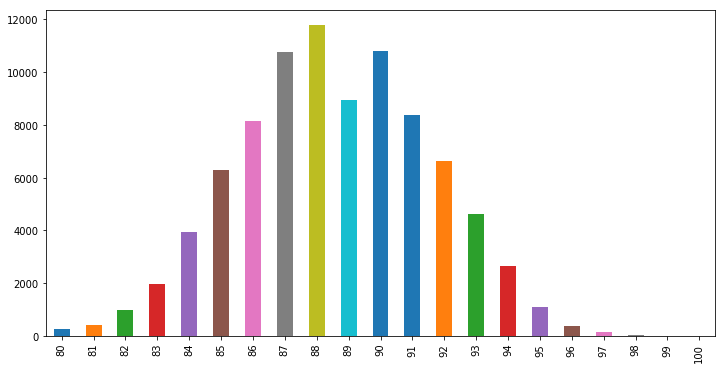

In [10]:
# Scores by occurences
clean_data['points'].value_counts().sort_index().plot.bar(figsize =(12,6))

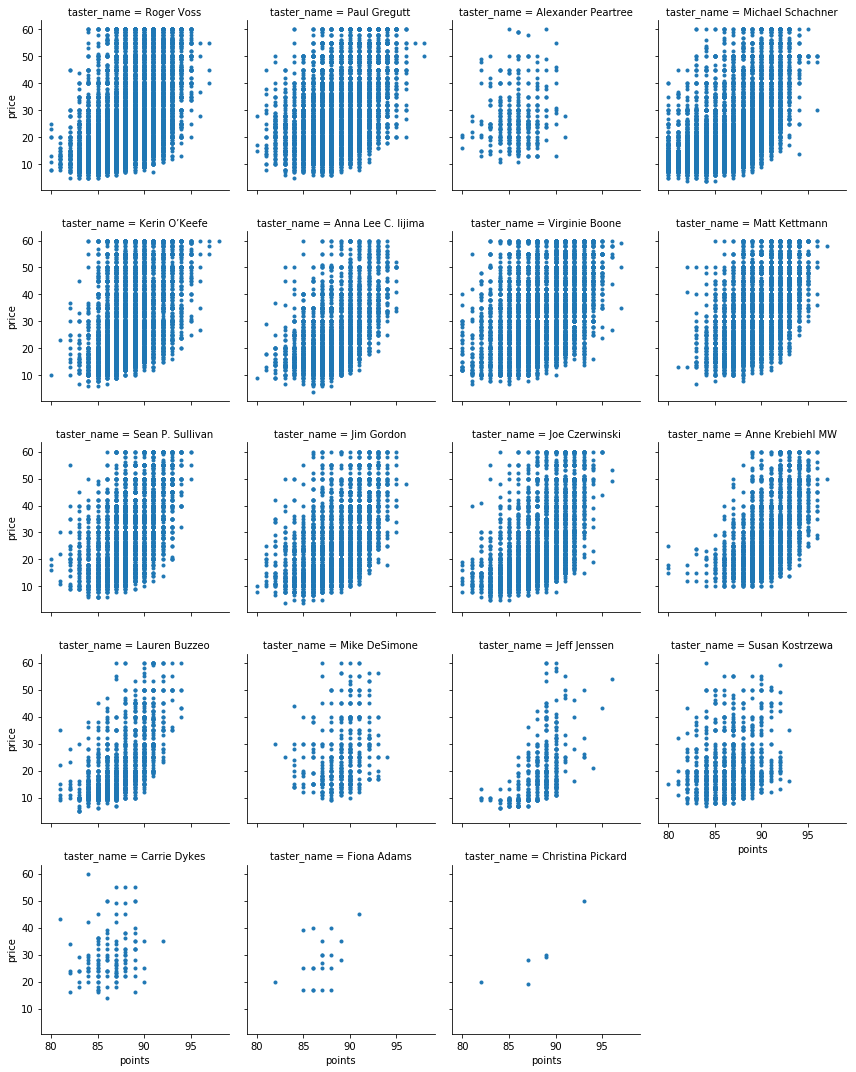

In [11]:
# Plotting price and point distributions 
# TASTERS
gT = sns.FacetGrid(affordable_wine, col="taster_name", col_wrap=4) 
gT = gT.map(plt.scatter, "points", "price", marker = ".")


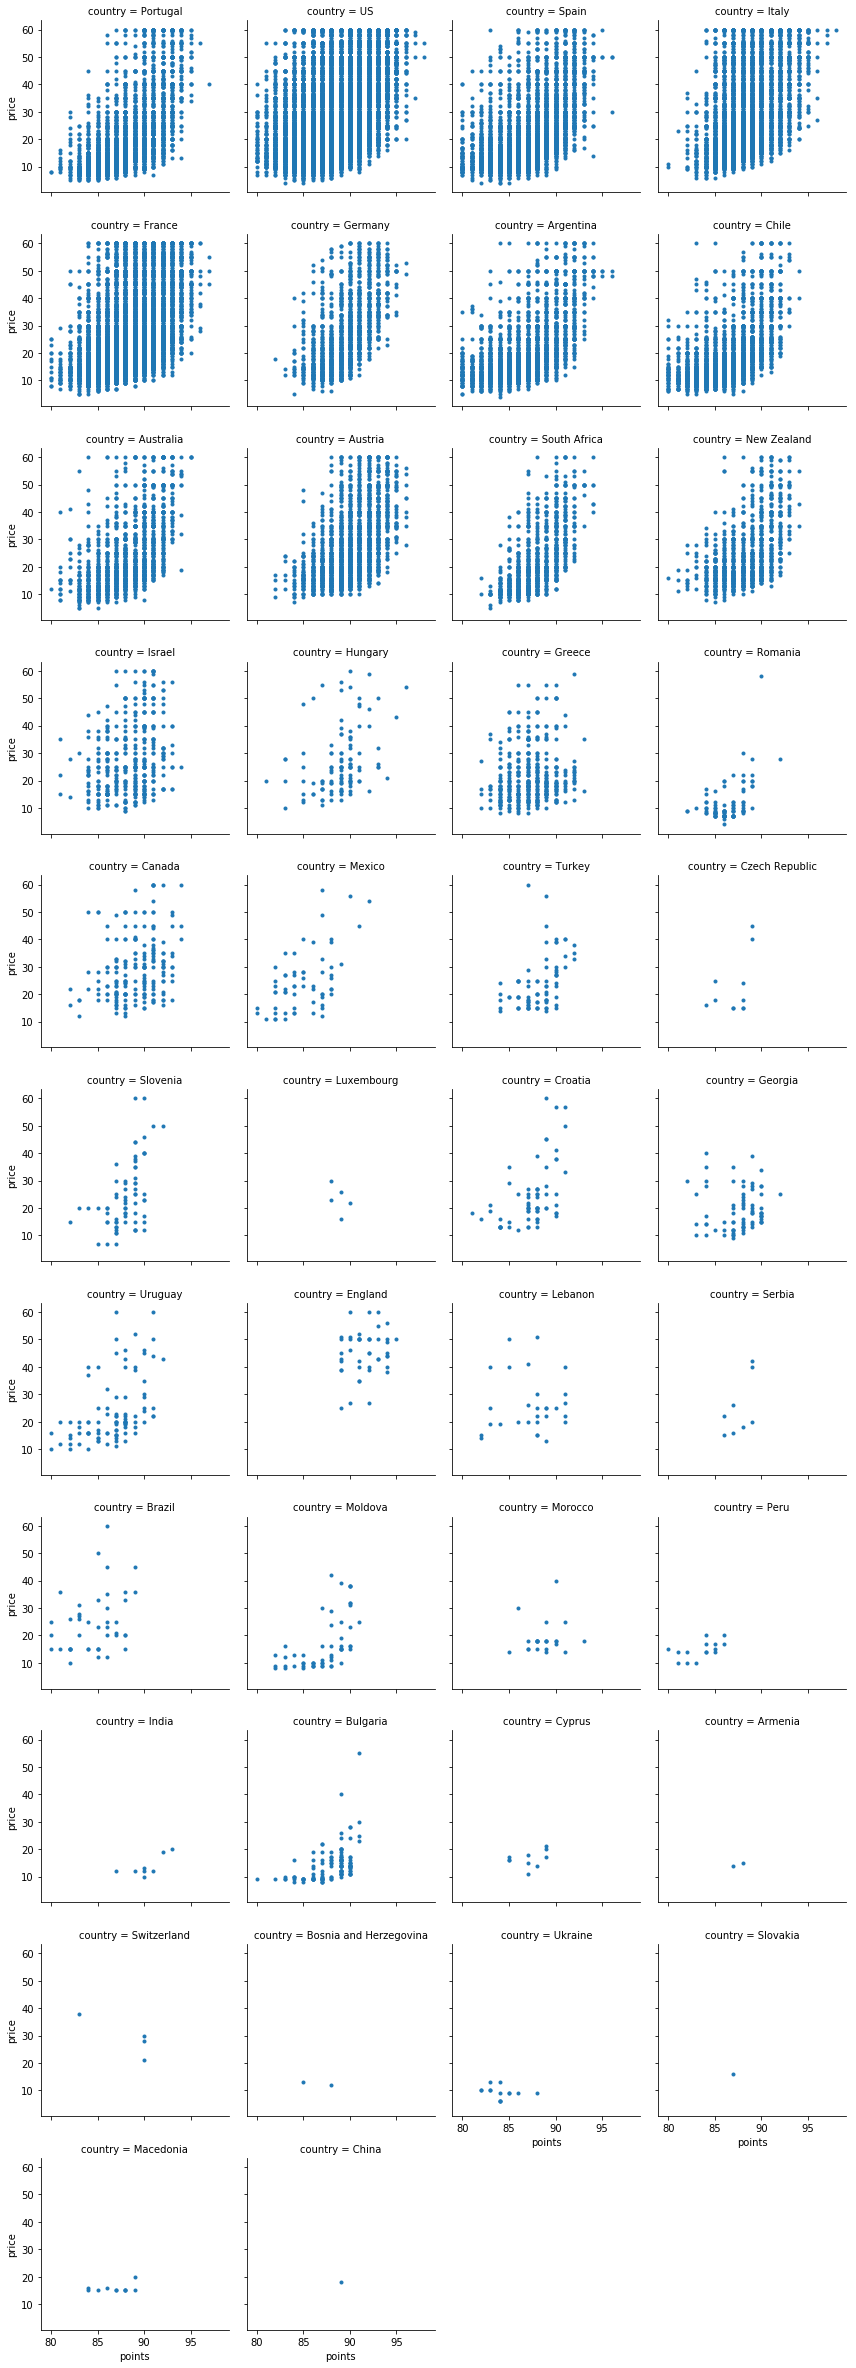

In [12]:
# Plotting price and point distributions 
# COUNTRIES
gC = sns.FacetGrid(affordable_wine, col="country", col_wrap=4) 
gC = gC.map(plt.scatter, "points", "price", marker = ".")

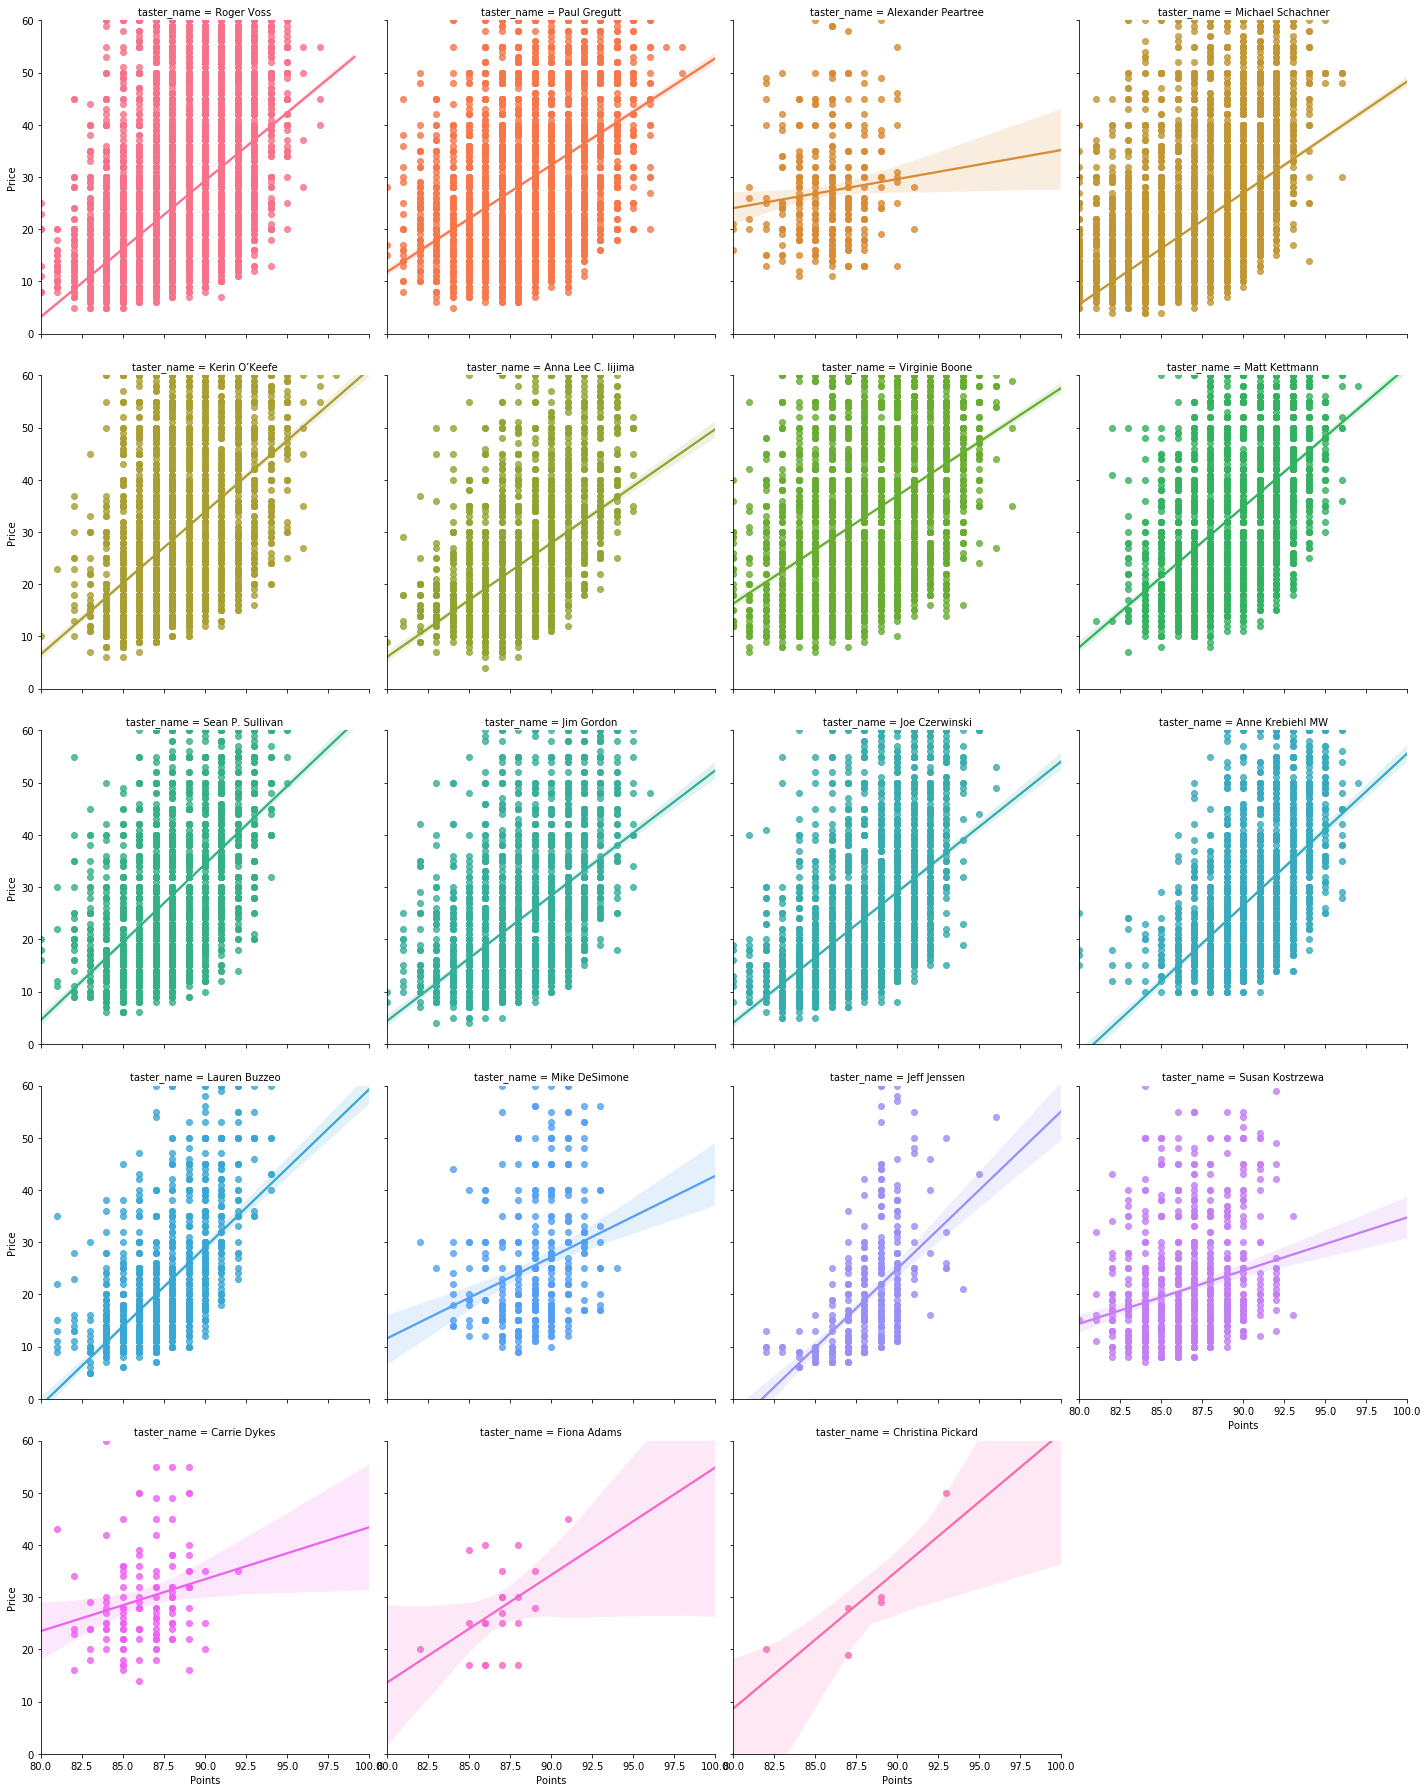

In [13]:
# Scatterplots of points to price, including linear regression lines
# TASTERS
g1T = sns.lmplot(x="points", y="price", col="taster_name", hue="taster_name",
               data=affordable_wine, col_wrap=4)
g1T = (g1T.set_axis_labels("Points", "Price")
      .set(xlim=(80,100), ylim=(0,60)))


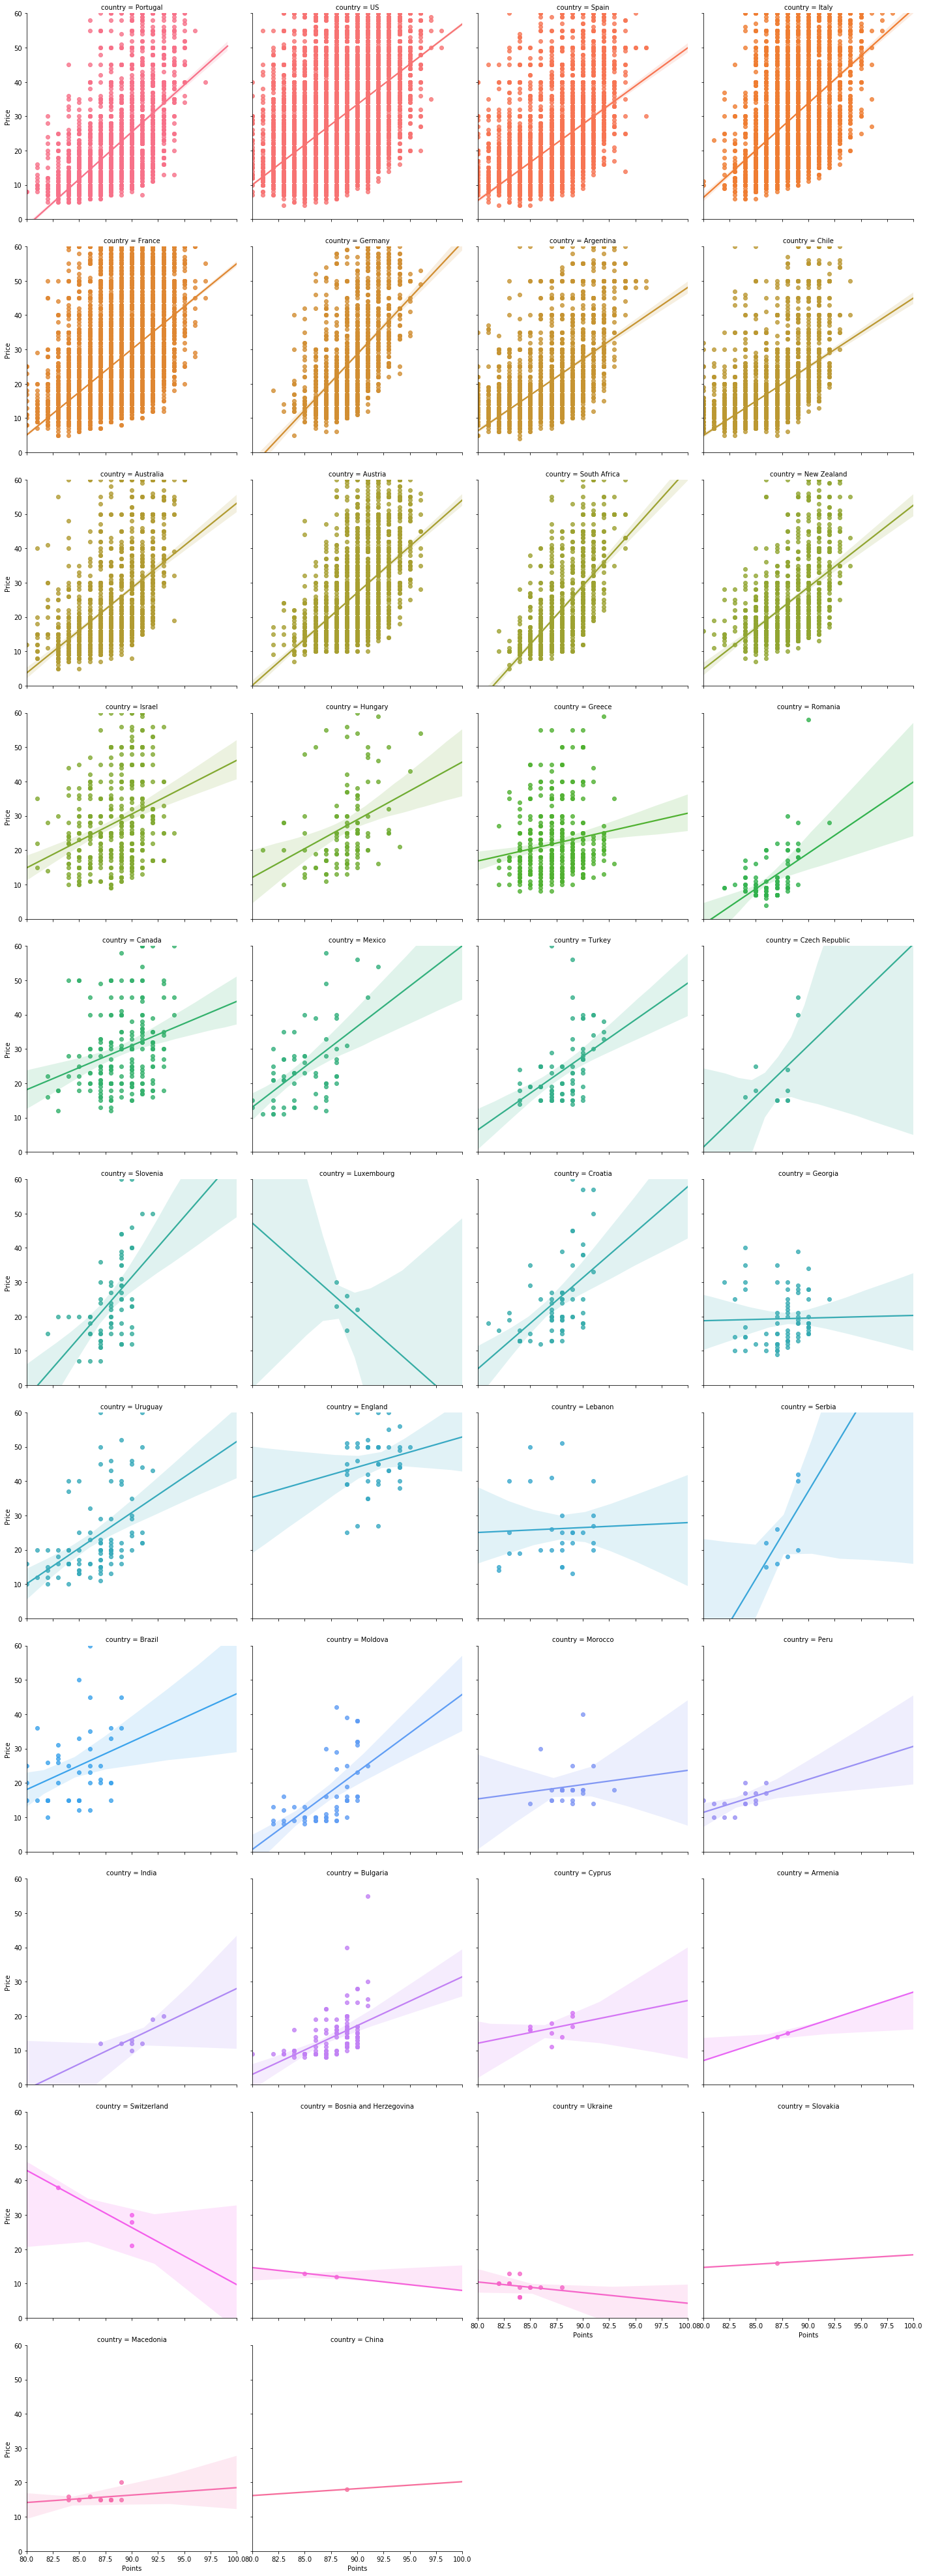

In [14]:
# Scatterplots of points to price, including linear regression lines
# By country
g1C = sns.lmplot(x="points", y="price", col="country", hue="country",
               data=affordable_wine, col_wrap=4)
g1C = (g1C.set_axis_labels("Points", "Price")
      .set(xlim=(80,100), ylim=(0,60)))

In [15]:
#Define Hexmaps, to be used to look at areas of highest concentration of touples
def hexbin(x, y, color, **kwargs):
    cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, gridsize=15, cmap=cmap, **kwargs)

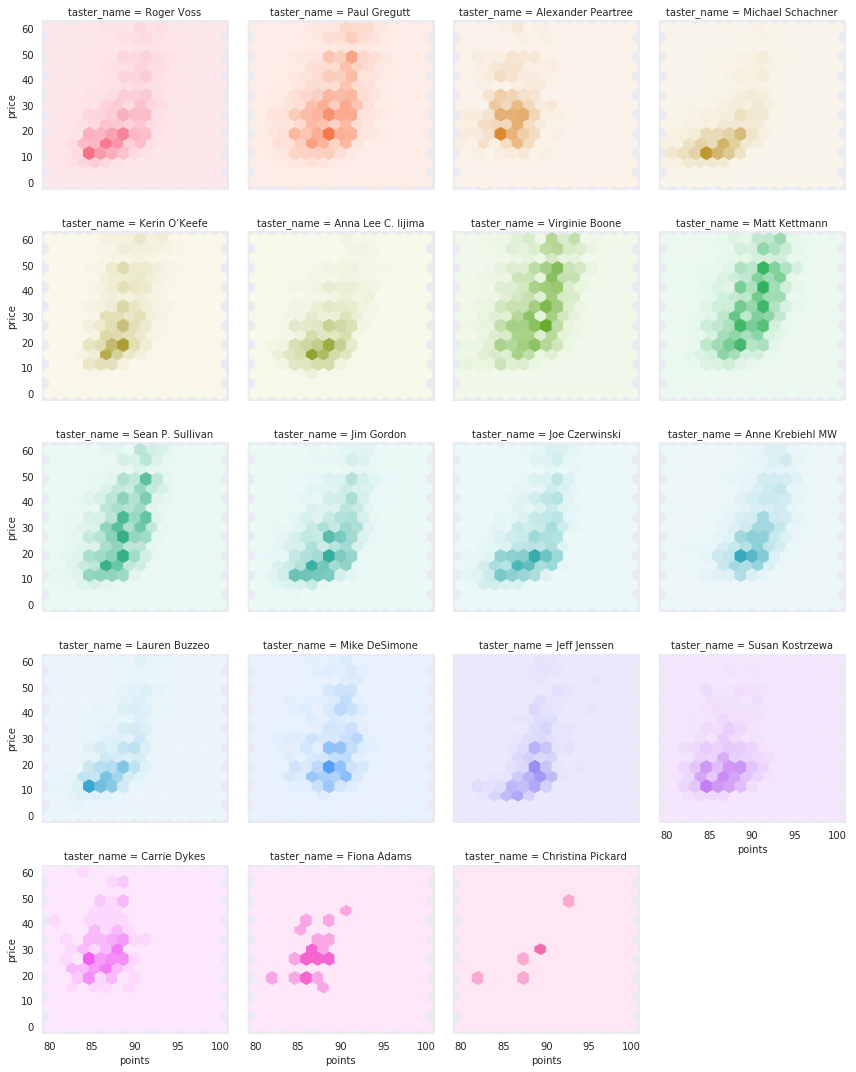

In [16]:
# Using Hexmaps to understand the concentration of points/price
# Tasters

with sns.axes_style("dark"):
    g2T = sns.FacetGrid(affordable_wine, hue="taster_name", col="taster_name", col_wrap=4)
g2T.map(hexbin, "points", "price", extent=[80,100,0,60]);

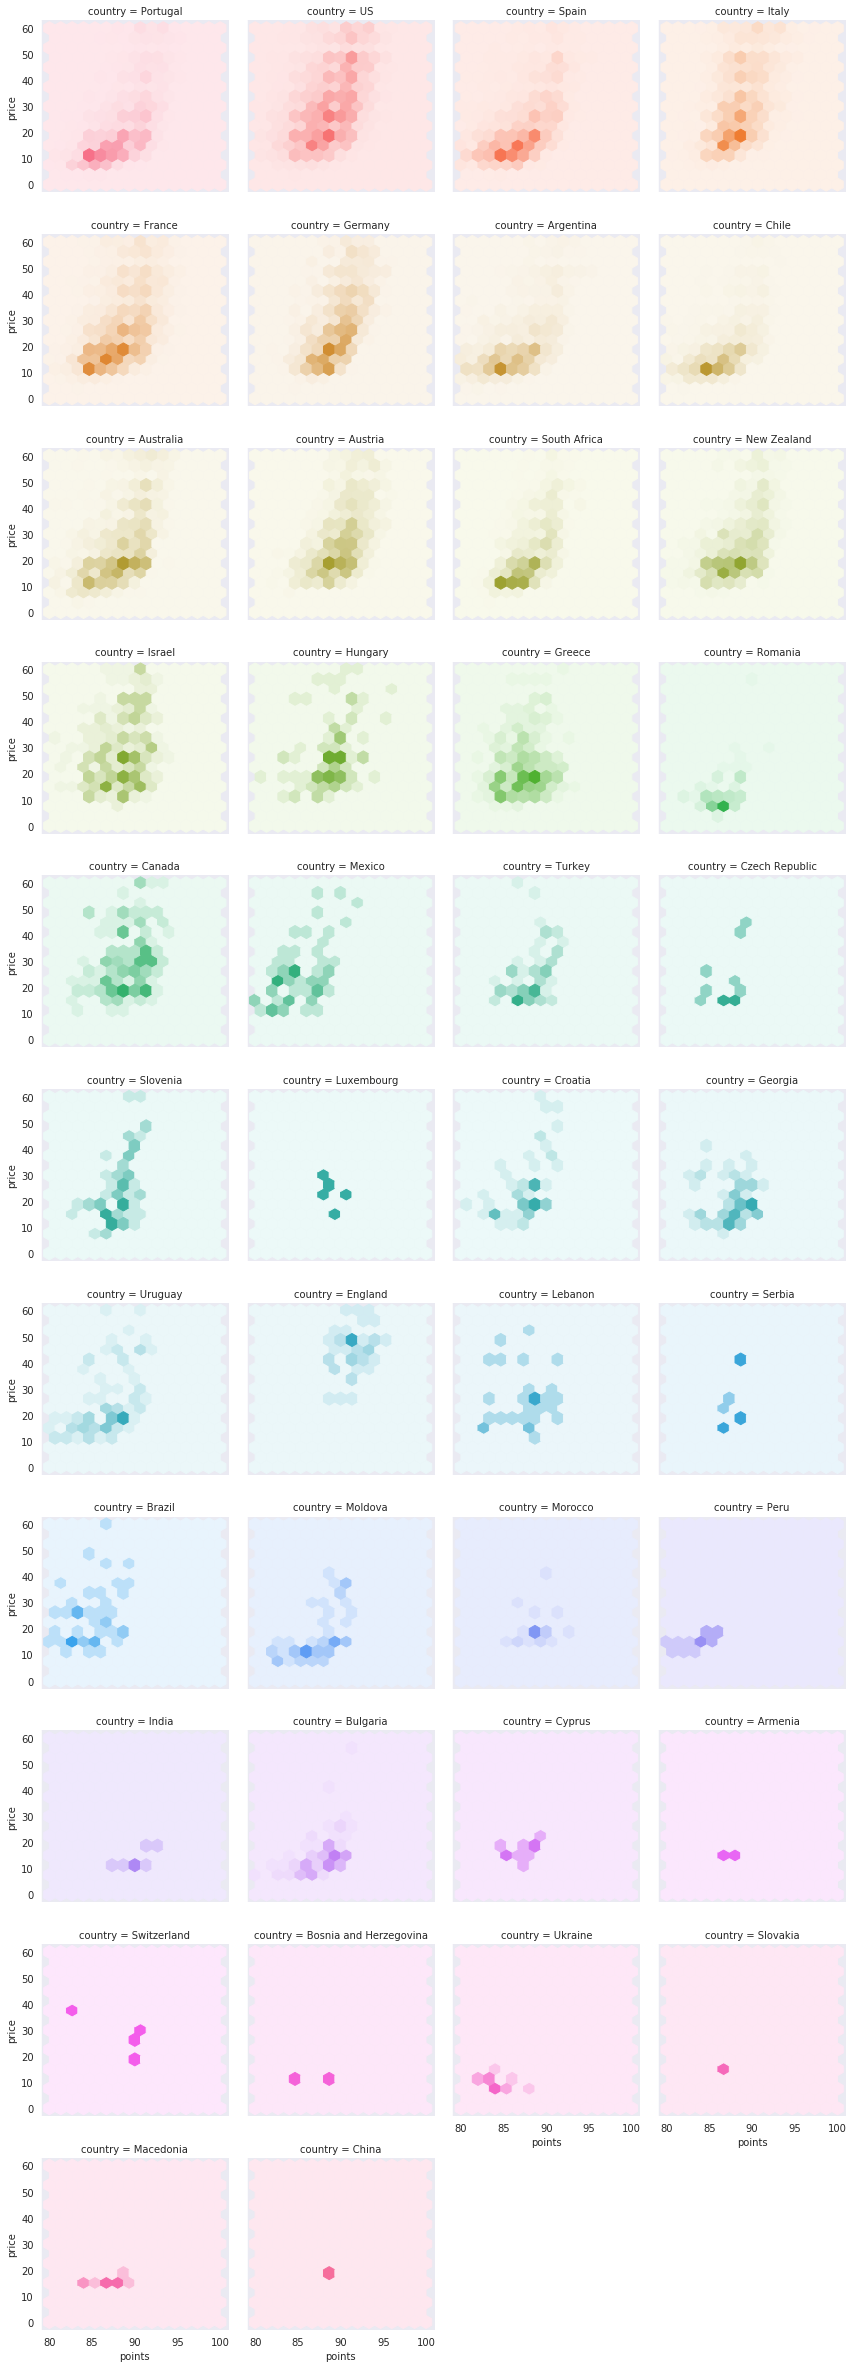

In [17]:
# Using Hexmaps to understand the concentration of points/price
# Countries

#g2C = sns.FacetGrid(affordable_wine, col="country", palette="GnBu_d", col_wrap=4)
#g2C.map(plt.hexbin, "points", "price", gridsize=15)

with sns.axes_style("dark"):
    g2T = sns.FacetGrid(affordable_wine, hue="country", col="country", col_wrap=4)
g2T.map(hexbin, "points", "price", extent=[80,100,0,60]);

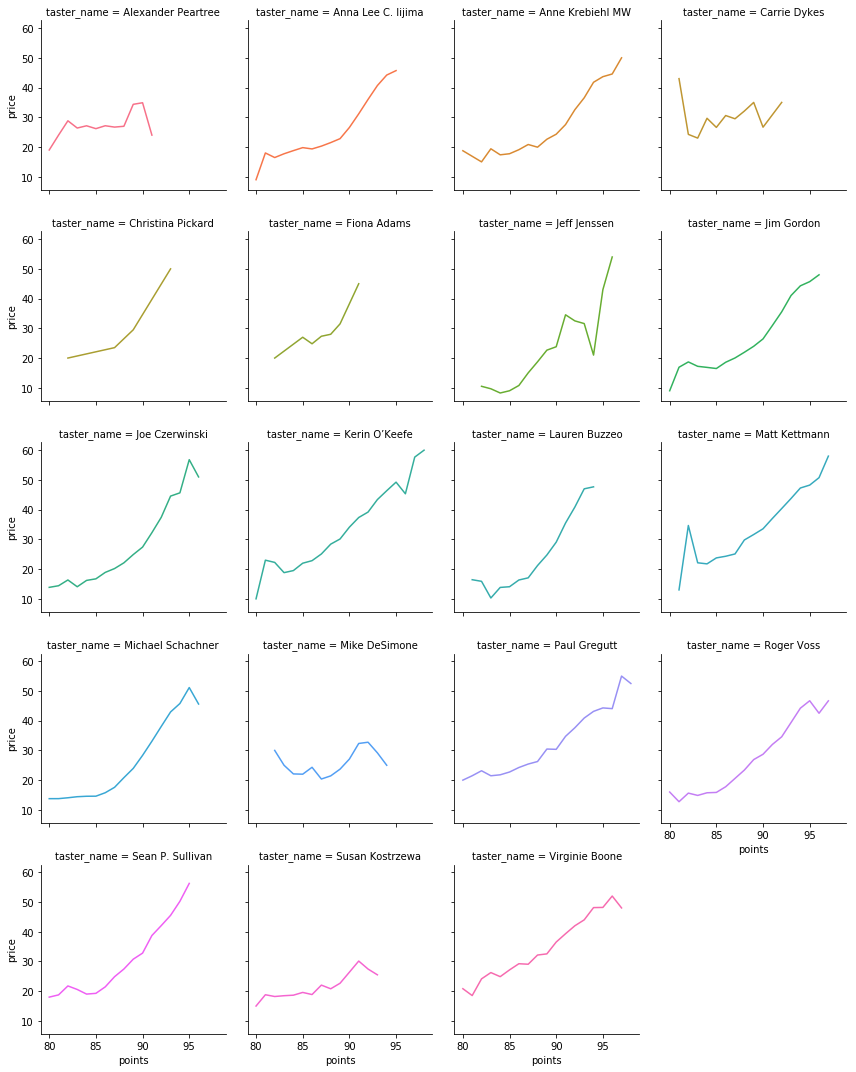

In [18]:
# Mean price Distributions
# Tasters
name_points = affordable_wine.groupby(['taster_name', 'points'])
g4T = sns.FacetGrid(name_points['price'].mean().reset_index(),
                  col='taster_name', hue='taster_name',
                  col_wrap=4,size=3)
g4T.map(plt.plot, "points","price")
g4T.fig.tight_layout(w_pad=1.5)

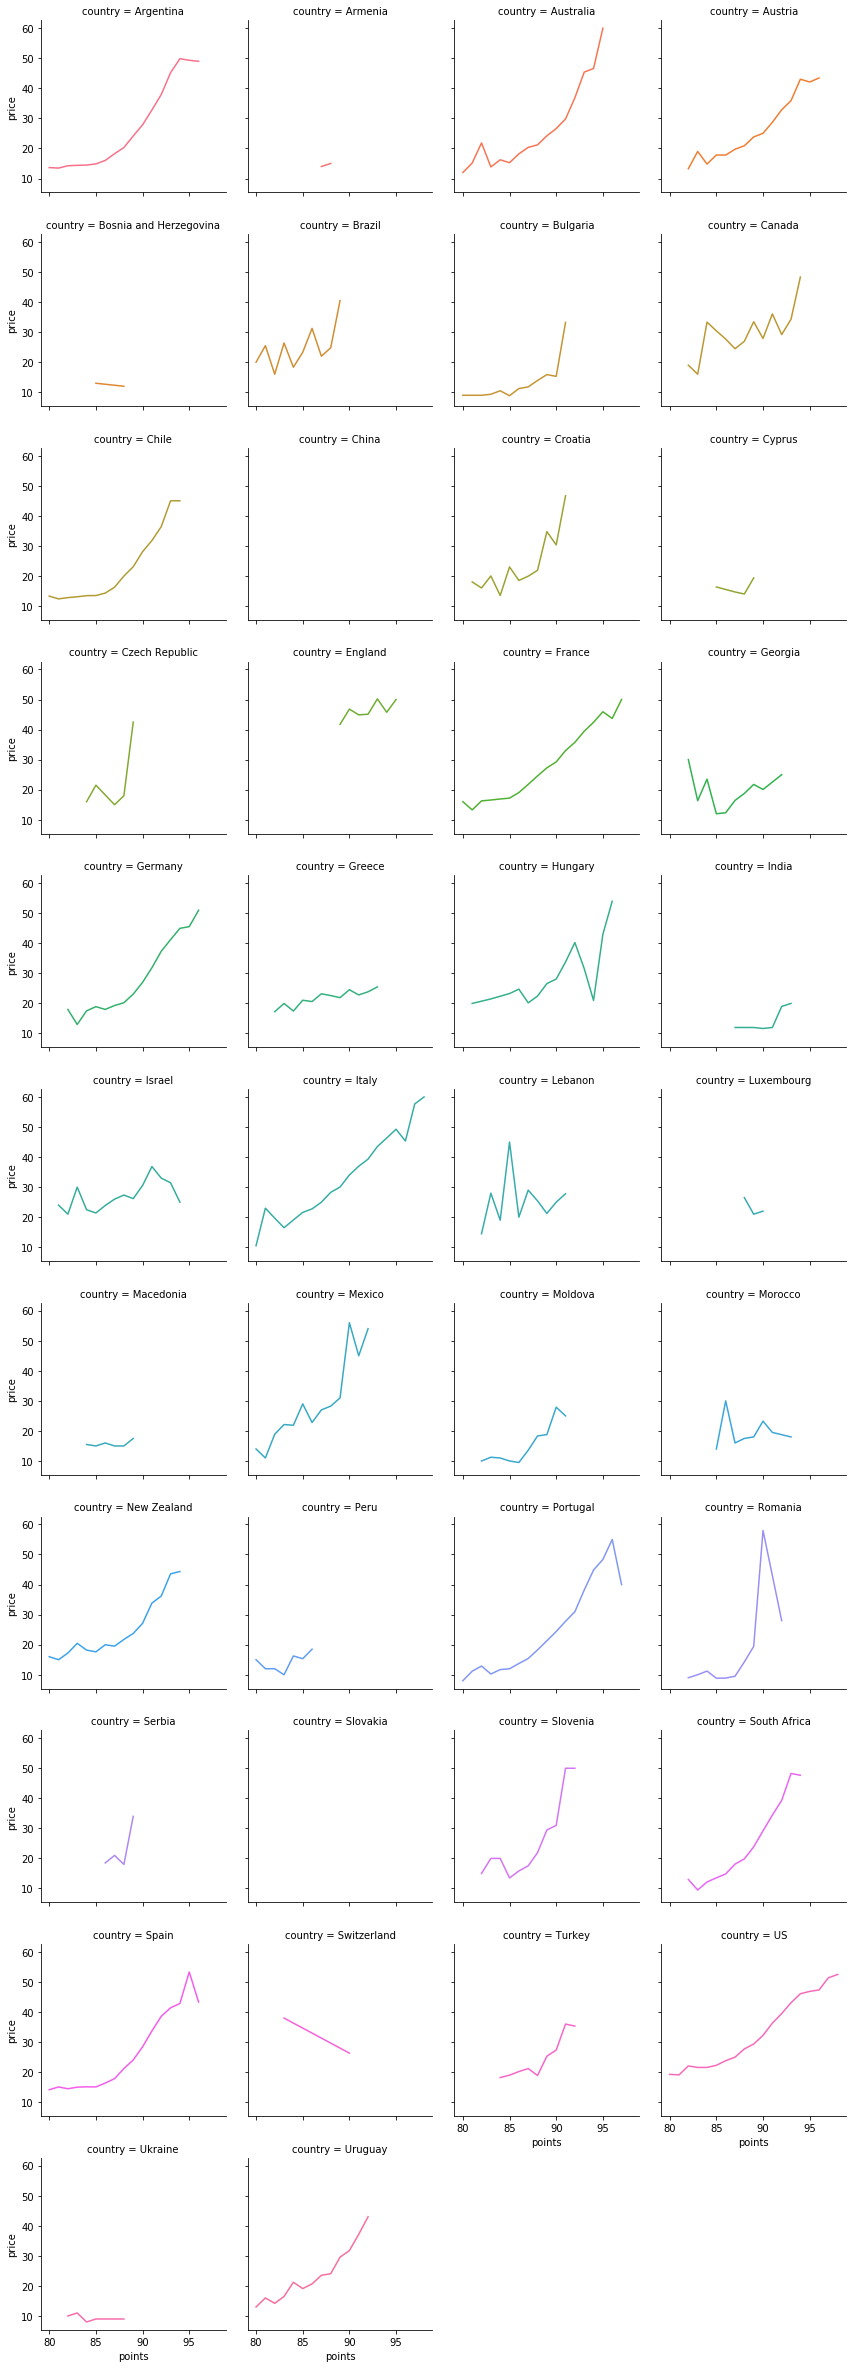

In [19]:
# Distributions between country, price and points, etc. 
#Country
country_points_pref = affordable_wine.groupby(['country', 'points'])
g4C = sns.FacetGrid(country_points_pref['price'].mean().reset_index(),
                  col='country', hue='country',
                  col_wrap=4,size=3)
g4C.map(plt.plot, "points","price")
g4C.fig.tight_layout(w_pad=1.5)

In [20]:
pricePointCountry = pd.DataFrame(affordable_wine.groupby('country')['points','price'].mean())
pricePointCountry.columns=['Average Points','Average Price']
pricePointCountry['Points per Dollar'] = pricePointCountry['Average Points']/pricePointCountry['Average Price']
pricePointCountry

Average Points  Average Price  Points per Dollar
country                                                                 
Argentina                    86.305556      19.439560           4.439687
Armenia                      87.500000      14.500000           6.034483
Australia                    88.211382      24.005003           3.674708
Austria                      89.998291      27.056386           3.326323
Bosnia and Herzegovina       86.500000      12.500000           6.920000
Brazil                       84.613636      24.500000           3.453618
Bulgaria                     87.862595      14.190840           6.191501
Canada                       89.116751      29.883249           2.982164
Chile                        86.279709      17.478983           4.936197
China                        89.000000      18.000000           4.944444
Croatia                      87.378788      24.333333           3.590909
Cyprus                       87.100000      16.500000           5.278788
Czech Republic               87.090909      22.363636           3.894309
England                      91.577778      45.444444           2.015159
France                       88.134841      25.389084           3.471367
Georgia                      87.594595      19.364865           4.523378
Germany                      89.465286      26.897686           3.326133
Greece                       87.238208      21.875000           3.988032
Hungary                      88.892857      27.000000           3.292328
India                        90.250000      13.750000           6.563636
Israel                       88.398058      28.012136           3.155706
Italy                        88.439092      29.497744           2.998165
Lebanon                      87.275862      26.068966           3.347884
Luxembourg                   88.800000      23.400000           3.794872
Macedonia                    86.818182      15.636364           5.552326
Mexico                       85.081967      24.983607           3.405512
Moldova                      87.142857      16.732143           5.208111
Morocco                      88.708333      18.958333           4.679121
New Zealand                  88.210478      24.387868           3.616982
Peru                         83.466667      14.733333           5.665158
Portugal                     87.997859      19.922436           4.417023
Romania                      86.310000      11.440000           7.544580
Serbia                       87.625000      24.875000           3.522613
Slovakia                     87.000000      16.000000           5.437500
Slovenia                     88.043478      24.608696           3.577739
South Africa                 87.717757      21.266355           4.124720
Spain                        86.904174      20.811434           4.175790
Switzerland                  88.250000      29.250000           3.017094
Turkey                       88.100000      23.762500           3.707522
US                           88.677100      30.341609           2.922624
Ukraine                      84.071429       9.214286           9.124031
Uruguay                      86.642105      23.842105           3.633996

In [21]:
pricePointTaster = pd.DataFrame(affordable_wine.groupby('taster_name')['points','price'].mean())
pricePointTaster.columns=['Average Points','Average Price']
pricePointTaster['Points per Dollar'] = pricePointTaster['Average Points']/pricePointTaster['Average Price']
pricePointTaster

Average Points  Average Price  Points per Dollar
taster_name                                                         
Alexander Peartree       85.741935      27.233871           3.148357
Anna Lee C. Iijima       88.160944      23.874732           3.692646
Anne Krebiehl MW         90.452026      27.835821           3.249483
Carrie Dykes             86.309524      29.769841           2.899227
Christina Pickard        87.833333      29.333333           2.994318
Fiona Adams              86.818182      27.681818           3.136289
Jeff Jenssen             88.241975      19.570370           4.508958
Jim Gordon               88.450097      24.632845           3.590738
Joe Czerwinski           88.068966      24.208621           3.637918
Kerin O’Keefe            88.464833      29.681445           2.980476
Lauren Buzzeo            87.316279      20.886379           4.180537
Matt Kettmann            89.889106      34.519851           2.603983
Michael Schachner        86.546302      19.593914           4.416999
Mike DeSimone            89.038278      25.622010           3.475070
Paul Gregutt             88.829719      29.873086           2.973570
Roger Voss               88.031716      24.147761           3.645544
Sean P. Sullivan         88.482393      29.857917           2.963448
Susan Kostrzewa          86.509664      21.003052           4.118909
Virginie Boone           88.686363      34.232135           2.590734

In [22]:
def regressions(input_data):

    #
    # Preparing the data for regressions
    #
    print(' Total touples: ',len(input_data))
    
    # ignore low input size
    if len(input_data) < 8:
        return
    
    # Normalize data on 0 to 1 interval
    input_data['price'] = (input_data['price']-input_data['price'].min() + .001) / (input_data['price'].max() - input_data['price'].min())
    input_data['points'] = (input_data['points']-input_data['points'].min() + .001) / (input_data['points'].max() - input_data['points'].min())

    # Split the model into 80% training and 20% testing splits
    training, test = train_test_split(input_data, train_size=.8, shuffle=True)

    # instantiate, train model
    # set alpha between 0-10 with 0.2 step
    # set cross validation to 8 groups
    ridge_model = RidgeCV(alphas=np.arange(0,10,.2), cv=8)

    # fit the training mode to the test model 
    ridge_model.fit(np.vstack(training['price'].values), np.vstack(training['points'].values))

    # return R-squares score for each model
    percent_dec = ridge_model.score(np.vstack(test['price']),np.vstack(test['points']))
    percent_mult = percent_dec*100
    percent = '%.3f'%(percent_mult) # truncate floating point 
        
    print(' R-squared value (test data "variance"):', percent, '%', '\n') 


In [23]:
# run linear regression on entire DataSet
regressions(affordable_wine)

 Total touples:  78632
 R-squared value (test data "variance"): 29.968 % 



In [24]:
#Run regressions by taster to see if easier to predict price via points by taster_name

tasterGroup = affordable_wine.groupby('taster_name')

for name, group in tasterGroup:
    if len(group) > 8:
        print(name, end=' ')
        regressions(group)
        print()


Alexander Peartree  Total touples:  372
 R-squared value (test data "variance"): -0.308 % 


Anna Lee C. Iijima  Total touples:  3728
 R-squared value (test data "variance"): 22.889 % 


Anne Krebiehl MW  Total touples:  2814
 R-squared value (test data "variance"): 27.219 % 


Carrie Dykes  Total touples:  126
 R-squared value (test data "variance"): -5.156 % 


Fiona Adams  Total touples:  22
 R-squared value (test data "variance"): -105.946 % 


Jeff Jenssen  Total touples:  405
 R-squared value (test data "variance"): 23.546 % 


Jim Gordon  Total touples:  3617
 R-squared value (test data "variance"): 21.550 % 


Joe Czerwinski  Total touples:  4060
 R-squared value (test data "variance"): 30.114 % 


Kerin O’Keefe  Total touples:  7308
 R-squared value (test data "variance"): 22.459 % 


Lauren Buzzeo  Total touples:  1505
 R-squared value (test data "variance"): 45.288 % 


Matt Kettmann  Total touples:  5113
 R-squared value (test data "variance"): 29.061 % 


Michael Schachner

In [25]:
#Run regressions by country to see if easier to predict price via points in certain countries

countryGroup = affordable_wine.groupby('country')

for name, group in countryGroup:
    if len(group) > 8:
        print(name, end=' ')
        regressions(group)
        print()

Argentina  Total touples:  3276
 R-squared value (test data "variance"): 36.584 % 


Australia  Total touples:  1599
 R-squared value (test data "variance"): 29.810 % 


Austria  Total touples:  2341
 R-squared value (test data "variance"): 30.191 % 


Brazil  Total touples:  44
 R-squared value (test data "variance"): -92.264 % 


Bulgaria  Total touples:  131
 R-squared value (test data "variance"): 13.698 % 


Canada  Total touples:  197
 R-squared value (test data "variance"): 11.411 % 


Chile  Total touples:  3854
 R-squared value (test data "variance"): 27.962 % 


Croatia  Total touples:  66
 R-squared value (test data "variance"): 42.224 % 


Cyprus  Total touples:  10
 R-squared value (test data "variance"): -148.891 % 


Czech Republic  Total touples:  11
 R-squared value (test data "variance"): -103.745 % 


England  Total touples:  45
 R-squared value (test data "variance"): -24.195 % 


France  Total touples:  13668
 R-squared value (test data "variance"): 27.649 % 


Geo

In [26]:
# plotting taster_name | variety over points x price
# THIS TAKES VERY LONG TO RUN (~3 Minutes), BUT LOOK INTO A WAY OF SCALING IT DOWN IN SCOPE
g3 = sns.lmplot(x="price", y="points", row="country", col="taster_name",
               data=affordable_wine)